In [1]:
# from utils.compression import compress_directories, decompress_directories

# base_path = "downloaded_data/gwilliams"
# destination_path = "data/gwilliams"

# decompress_directories(
#     base_path,
#     destination_path,
#     checksum_file_name="checksums.txt",
#     delete_compressed_files=True,
#     num_workers=None
# )

In [2]:
import gc
import random
import time
from tracemalloc import start
from tqdm import tqdm
from config.simpleconv_config import SimpleConvConfig
from models.simpleconv import SimpleConv
from studies.study_factory import StudyFactory
from utils.dataloader import ParallelDataLoader
from utils.pre_processor import PreProcessor
import typing as tp
import json
from itertools import product
from torch.optim import AdamW, Adam
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader
import os
import logging
import shutil
from utils.dataloader import ParallelDataLoader
from utils.clip import CLIPLoss

import torch

device = "cuda"

from config import SimpleConvConfig, Config


class TrainingConfigV0(Config):
    def __init__(
        self,
        brain_encoder_config: SimpleConvConfig,
        data_partition: tp.Dict[str, tp.Dict[str, tp.List[str]]],
        # Pre-processing parameters
        # Brain
        new_freq: int = 100,
        frequency_bands: tp.Tuple[str, tp.Tuple[int, int]] = {"all": (0.5, 100)},
        max_random_shift: float = 2.0,
        window_size: int = 4,
        window_stride: int = 1,
        brain_clipping: float = 20,
        baseline_window: int = 0.5,
        notch_filter: bool = True,
        # Audio
        audio_model: str = "openai/whisper-large-v3",
        audio_sample_rate: int = 16000,
        hop_length: int = 160,
        # Hyperparameters
        learning_rate: float = 3e-4,
        weight_decay: float = 1e-4,
        epochs: int = 50,
        batch_size: int = 128,
        use_clip_loss: bool = True,
        use_mse_loss: bool = True,
        alpha: float = 0.5,
        random_test_size: int = 3,
    ):
        self.brain_encoder_config = brain_encoder_config
        # key: study_name, value: dict with keys: "testing_subjects", "testing_tasks",
        # where each value is a list of int. Ones not specified in either lists are
        # used for training.
        self.data_partition = data_partition

        # Pre-processing parameters
        # Brain
        self.new_freq = new_freq
        self.frequency_bands = frequency_bands
        self.max_random_shift = max_random_shift
        self.window_size = window_size
        self.window_stride = window_stride
        self.baseline_window = baseline_window
        self.notch_filter = notch_filter
        self.brain_clipping = brain_clipping

        # Audio
        self.audio_model = audio_model
        self.audio_sample_rate = audio_sample_rate
        self.hop_length = hop_length

        # Hyperparameters
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.epochs = epochs
        self.batch_size = batch_size
        self.use_clip_loss = use_clip_loss
        self.use_mse_loss = use_mse_loss
        self.alpha = alpha
        self.random_test_size = random_test_size

        assert 0 <= self.alpha <= 1, "Alpha must be between 0 and 1"
        assert use_clip_loss or use_mse_loss, "At least one loss function must be used"

    # does not overide parent method
    def to_dict_(self):
        brain_encoder_config = self.brain_encoder_config.to_dict()
        config = self.to_dict()
        config["brain_encoder_config"] = brain_encoder_config
        return config


class TrainingSessionV0:
    def __init__(
        self,
        config: TrainingConfigV0,
        studies: tp.List[str],
        data_path: str = "/home/ubuntu/brain-decoding/data",
        save_path: str = "/home/ubuntu/brain-decoding/saves",
        clear_cache: bool = False,
    ):
        """Initializes a training session with the provided configuration and data.

        Arguments:
            config -- The configuration for the training session.
            studies -- list of studies to train on. Partition policy determined in TrainingConfig
            data_path -- The path to the data directory.
            save_path -- The path to the directory where the model and logs will be saved.
        """
        assert len(studies) > 0, "At least one study root path must be provided"
        assert all(
            os.path.exists(data_path + "/" + study) for study in studies
        ), "All study root paths must exist"
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        logging.basicConfig(
            filename=os.path.join(save_path, "training_log.log"),
            level=logging.INFO,
            format="%(asctime)s %(message)s",
            filemode="w",
        )
        self.logger = logging.getLogger()

        self.config = config
        self.data_path = data_path
        self.save_path = save_path

        # Create studies accessor
        self.studies = {}
        for study in studies:
            path = os.path.join(data_path, study)
            try:
                self.studies[study] = StudyFactory.create_study(study, path)
                if clear_cache:
                    shutil.rmtree(study.cache_dir)
                    os.makedirs(study.cache_dir)
                    self.log_print(f"Cleared cache for study {study}")
            except ValueError as e:
                self.log_print(f"Error loading study {study}: {e}")

        # Create preprocessor
        self.pre_processor = PreProcessor()

        self.dataset = {
            "train": [],
            "test": {
                "unseen_subject": [],
                "unseen_task": [],
                "unseen_both": [],
            },
        }

        self.partition_data()

        self.metrics = {
            "train": [],
            "test": {
                "unseen_subject": [],
                "unseen_task": [],
                "unseen_both": [],
            },
        }

        # If subject layer, assign a unique int to each subject in the dataset
        self.subject_mapping, n = {}, 0
        for study_name, study in self.studies.items():
            for subject in study.subjects_list:
                self.subject_mapping[f"{study_name}_{subject}"] = n
                n += 1
        self.config.brain_encoder_config.n_subjects = n

        self.model = SimpleConv(self.config.brain_encoder_config)
        self.error = None
        self.optimizer = Adam(
            self.model.parameters(),
            lr=self.config.learning_rate,
            weight_decay=self.config.weight_decay,
        )

    def partition_data(self):
        """
        Partitions the data into training and various testing sets, based on
        the named holdout sessions and tasks specified in TrainingConfig
        """
        for study_name, study in self.studies.items():

            if study_name not in self.config.data_partition:
                raise ValueError(f"Study {study_name} not found in data partition")

            data_partition = self.config.data_partition[study_name]

            for subject, task, session in product(
                [i for i in range(len(study.subjects_list))],
                [i for i in range(len(study.tasks))],
                [i for i in range(len(study.sessions))],
            ):
                # If recording exists
                try:
                    recording = study.recordings[subject][task][session]
                except IndexError:
                    # self.logger.error(f"Recording not found for {study_name} {subject} {task} {session}")
                    continue

                # Unseen both and task
                if subject in data_partition["testing_subjects"]:
                    if task in data_partition["testing_tasks"]:
                        self.dataset["test"]["unseen_both"].append(
                            (study_name, subject, task, session)
                        )
                    else:
                        self.dataset["test"]["unseen_task"].append(
                            (study_name, subject, task, session)
                        )
                # Unseen subject and train
                else:
                    if task in data_partition["testing_tasks"]:
                        self.dataset["test"]["unseen_subject"].append(
                            (study_name, subject, task, session)
                        )
                    else:
                        self.dataset["train"].append(
                            (study_name, subject, task, session)
                        )

        self.log_print(
            f"Data partitioned on studies {list(self.studies.keys())}. Recordings:"
        )
        self.log_print(
            f"Train: {len(self.dataset['train'])}, Unseen Task: {len(self.dataset['test']['unseen_task'])}, Unseen Subject: {len(self.dataset['test']['unseen_subject'])}, Unseen Both: {len(self.dataset['test']['unseen_both'])}.\n"
        )

    def train(self, device: str, buffer_size: int, num_workers: int):

        # Set all training parameters
        self.device = device
        gpu_ok = False
        torch.set_float32_matmul_precision("high")
        training_size = len(self.dataset["train"])
        self.scaler = GradScaler()
        self.model.to(device)

        # Check if GPU is NVIDIA V100, A100, or H100
        if torch.cuda.is_available():
            device_cap = torch.cuda.get_device_capability()
            if device_cap in ((7, 0), (8, 0), (9, 0)):
                gpu_ok = True

        if not gpu_ok:
            self.log_print(
                "GPU is not NVIDIA V100, A100, or H100. Speedup numbers may be lower than expected."
            )

        for epoch in range(1, self.config.epochs + 1):
            try:
                self.model.to(device).train()
                
                epoch_start_time = time.time()

                # Shuffle for each epoch, and start fetching
                epoch_training_dataset, remaining = (
                    self.dataset["train"].copy(),
                    training_size,
                )
                random.shuffle(epoch_training_dataset)
                loader = self.get_data_loader(
                    buffer_size=buffer_size, num_workers=num_workers
                )
                loader.start_fetching(epoch_training_dataset)

                # Run each batch
                while True:

                    recording = loader.get_recording()

                    if recording is None:
                        break

                    try:
                        start_time = time.time()

                        results = self.run_recording(recording, train=True)
                        self.metrics["train"].append(results)

                        # Don't print, just log
                        self.logger.info(
                            f"Epoch {epoch}, Remaining {remaining}/{training_size}. Runtime {time.time() - start_time:.2f}s."
                        )
                        self.logger.info(
                            f'Loss: {results["loss"]:.4f}, Clip Loss: {results["clip_loss"]:.4f}, MSE Loss: {results["mse_loss"]:.4f}'
                        )
                        self.logger.info(
                            f'Accuracy: {results["accuracy"]:.4f}, Top 1: {results["top_1_accuracy"]:.4f}, Top 5: {results["top_5_accuracy"]:.4f}, Top 10: {results["top_10_accuracy"]:.4f}'
                        )
                        remaining -= 1
                    except:
                        # Do log errors
                        self.log_print(
                            f'Error in epoch {epoch}, {recording.metadata["study"]} {recording.metadata["subject"]} {recording.metadata["task"]} {recording.metadata["session"]}'
                        )
                        continue
                
                # Save model after each epoch
                elapsed_minutes = (time.time() - epoch_start_time) / 60
                self.logger.info(
                    f"Epoch {epoch} completed in {elapsed_minutes:.2f}m. {elapsed_minutes / training_size:.2f}m per recording."
                )
                # Testing
                self.log_print(f"Testing at epoch {epoch}")
                with torch.no_grad():
                    self.test(buffer_size=9, num_workers=3)

            except Exception as e:
                self.log_print(f"Error in epoch {epoch}, {e}")
                self.save(f"error_epoch_{epoch}")
                raise e
            
            self.save(f"epoch_{epoch}")

        self.log_print("Training completed.")

    def run_recording(self, recording, train: bool) -> tp.Dict[str, float]:
        """
        Per recording processing for training and testing. Returns average metrics
        and losses for the recording. Returns metrics on CPU.
        """
        recording_loss, recording_clip_loss, recording_mse_loss = 0, 0, 0
        (total, missed_recordings, missed_batches) = (
            brain_segments.shape[0],
            0,
            0,
        )
        (
            recording_correct,
            recording_top_1,
            recording_top_5,
            recording_top_10,
        ) = (
            0,
            0,
            0,
            0,
        )

        with autocast(dtype=torch.bfloat16):
            # Some processing to ensure dims match
            brain_segments, audio_segments, layout, metadata = recording
            brain_segments, audio_segments = self.discard_nan(
                brain_segments["all"], audio_segments
            )

            # Subject indices from the session mapping
            subject_indices = torch.full(
                (brain_segments.shape[0]),
                self.subject_mapping[metadata["study"] + "_" + metadata["subject"]],
                dtype=torch.int64,
                requires_grad=False,
            ).to(
                self.device
            )  # [B]

            # Move self.device
            brain_segments, audio_segments, layout = (
                brain_segments.to(self.device),
                audio_segments.to(self.device),
                layout.to(self.device),
            )  # [B, C, T], [B, mel_bins, T], [C, 2]

            # Process by specified batch size
            batch_indices = [
                (i, min(i + self.config.batch_size, total))
                for i in range(0, total, self.config.batch_size)
            ]
            for start, end in batch_indices:

                if train:
                    self.optimizer.zero_grad()

                # Slice by batch
                brain_batch, audio_batch, subject_batch = (
                    brain_segments[start:end],
                    audio_segments[start:end],
                    subject_indices[start:end],
                )
                # Forward pass
                output = self.model(
                    inputs={"meg": brain_batch},
                    layout=layout,
                    subjects=subject_batch,
                )  # [B, C, T]

                # Compute loss
                mse_loss = torch.nn.functional.mse_loss(
                    input=output, target=audio_batch, size_average=True
                )
                clip_results = CLIPLoss().forward(x_1=output, x_2=audio_batch)
                clip_loss, clip_metrics = clip_results["loss"], clip_results["metrics"]

                if self.config.use_clip_loss and self.config.use_mse_loss:
                    loss = ((1 - self.config.alpha) * mse_loss) + (
                        self.config.alpha * clip_loss
                    )
                elif not self.config.use_clip_loss and self.config.use_mse_loss:
                    loss = mse_loss
                elif self.config.use_clip_loss and not self.config.use_mse_loss:
                    loss = clip_loss

                if not torch.isnan(loss).any():
                    # Backward pass
                    if train:
                        self.scaler.scale(loss).backward()
                        self.scaler.step(self.optimizer)
                        self.scaler.update()
                    # Store losses, move to CPU
                    recording_loss += loss.detach().to("cpu").item()
                    recording_clip_loss += clip_loss.detach().to("cpu").item()
                    recording_mse_loss += mse_loss.detach().to("cpu").item()
                    # Store metrics, already on CPU
                    recording_correct += clip_metrics["correct"]
                    recording_top_1 += clip_metrics["top_1_correct"]
                    recording_top_5 += clip_metrics["top_5_correct"]
                    recording_top_10 += clip_metrics["top_10_correct"]
                else:
                    self.logger.info(
                        f'Loss is NaN for recording {metadata["study"]} {metadata["subject"]} {metadata["task"]} {metadata["session"]}'
                    )
                    missed_recordings += end - start
                    missed_batches += 1
        gc.collect()
        torch.cuda.empty_cache()

        # Correct for missed recordings and batches
        total -= missed_recordings
        batches = len(batch_indices) - missed_batches

        # Loss divided by batches, metrics by total
        return {
            "loss": recording_loss / batches if batches > 0 else 0,
            "clip_loss": recording_clip_loss / batches if batches > 0 else 0,
            "mse_loss": recording_mse_loss / batches if batches > 0 else 0,
            "accuracy": recording_correct / total,
            "top_1_accuracy": recording_top_1 / total,
            "top_5_accuracy": recording_top_5 / total,
            "top_10_accuracy": recording_top_10 / total,
        }

    def test(self, buffer_size: int, num_workers: int):
        
        self.model.eval().to(self.device)
        
        test_start_time = time.time()
        
        test_datasets, test_dataloader = {}, {}
        # Create dataset and loader
        for test in self.dataset["test"].keys():
            # Randomly subsample recordings for each type of test
            if len(self.dataset["test"][test]) < self.config.random_test_size:
                test_datasets[test] = self.dataset["test"][test]
            else:
                test_datasets[test] = random.sample(
                    self.dataset["test"][test], self.config.random_test_size
                )
            # Create dataloader for each test
            test_dataloader[test] = self.get_data_loader(
                buffer_size=buffer_size, num_workers=num_workers
            )
            test_dataloader[test].start_fetching(test_datasets[test])
                
        test_sizes = {test: len(test_datasets[test]) for test in test_datasets.keys()}
        
        # Run tests
        for test in test_datasets.keys():
            while True:
                recording = test_dataloader[test].get_recording()
                
                if recording is None:
                    break
                
                try:
                
                    start_time = time.time()
                    
                    results = self.run_recording(recording, train=False)
                    self.metrics["test"][test].append(results)

                    # Log results
                    self.logger.info(
                        f"Testing {test} {test_sizes[test]}/{len(test_datasets[test])}. Runtime {time.time() - start_time:.2f}s."
                    )
                    self.logger.info(
                        f'Loss: {results["loss"]:.4f}, Clip Loss: {results["clip_loss"]:.4f}, MSE Loss: {results["mse_loss"]:.4f}'
                    )
                    self.logger.info(
                        f'Accuracy: {results["accuracy"]:.4f}, Top 1: {results["top_1_accuracy"]:.4f}, Top 5: {results["top_5_accuracy"]:.4f}, Top 10: {results["top_10_accuracy"]:.4f}'
                    )
                    
                except:
                    self.log_print(f'Error in testing {test} {recording.metadata["study"]} {recording.metadata["subject"]} {recording.metadata["task"]} {recording.metadata["session"]}')
                    test_sizes[test] -= 1
                    continue    
                
        # Log info
        elapsed_minutes = (time.time() - test_start_time) / 60
        self.logger.info(
            f"Testing completed in {elapsed_minutes:.2f}m."
        )

        return
                
    def pre_process_all_recordings(self, buffer_size: int, num_workers: int):
        """Pre-processes all data and saves as .pt in cache at once."""

        loader = self.get_data_loader(buffer_size=buffer_size, num_workers=num_workers)

        if (
            not self.dataset["train"]
            or not self.dataset["test"]["unseen_subject"]
            or not self.dataset["test"]["unseen_task"]
            or not self.dataset["test"]["unseen_both"]
        ):
            self.partition_data()

        all_recordings = (
            self.dataset["train"]
            + self.dataset["test"]["unseen_subject"]
            + self.dataset["test"]["unseen_task"]
            + self.dataset["test"]["unseen_both"]
        )  # (study, subject, task, session)

        random.shuffle(all_recordings)

        total_recordings, remaining = len(all_recordings), len(all_recordings)
        pbar = tqdm(total=total_recordings, desc="Loading recordings")

        loader.start_fetching(all_recordings)

        while True:
            recording = loader.get_recording()
            if recording is None:
                break
            remaining -= 1
            pbar.update(1)

    def get_data_loader(self, buffer_size: int, num_workers: int) -> ParallelDataLoader:
        return ParallelDataLoader(
            studies=self.studies,
            pre_processor=self.pre_processor,
            buffer_size=buffer_size,
            num_workers=num_workers,
            max_random_shift=self.config.max_random_shift,
            window_size=self.config.window_size,
            window_stride=self.config.window_stride,
            baseline_window=self.config.baseline_window,
            frequency_bands=self.config.frequency_bands,
            brain_clipping=self.config.brain_clipping,
            new_freq=self.config.new_freq,
            notch_filter=self.config.notch_filter,
            audio_sample_rate=self.config.audio_sample_rate,
            hop_length=self.config.hop_length,
            audio_processor=self.config.audio_model,
            n_jobs=1,
        )

    def save(self):
        pass

    def discard_nan(
        self,
        brain: torch.Tensor,
        audio: torch.Tensor,
    ):
        """
        If any nan in brain or audio data, discard the batch.

        Arguments:
            brain -- The brain data tensor, [B, C, T]
            audio -- The audio data, [B, mel_bins, T]
        """

        valid_mask = ~(
            torch.isnan(brain).any(dim=(1, 2)) | torch.isnan(audio).any(dim=(1, 2))
        )

        if valid_mask.all():
            return brain, audio

        # Apply the same mask to both tensors
        filtered_brain = brain[valid_mask]
        filtered_audio = audio[valid_mask]

        if filtered_brain.shape[0] != filtered_audio.shape[0]:
            raise ValueError(
                "Filtered brain and audio data must have the same number of samples"
            )

        return filtered_brain, filtered_audio

    def log_print(self, message):
        print(message)
        self.logger.info(message)


def load_training_session():
    pass


training_config = TrainingConfigV0(
    brain_encoder_config=SimpleConvConfig(merger_pos_dim=256),
    data_partition={
        "gwilliams": {
            "testing_subjects": [19, 20, 21],
            "testing_tasks": [0],
        },
        # "schoffelen": {
        #     "testing_subjects": [],
        #     "testing_tasks": [8, 9],
        # },

    },
    learning_rate=3e-4,
    weight_decay=1e-4,
)

session = TrainingSessionV0(
    training_config,
    studies=["gwilliams"],  # "schoffelen"
    data_path="data",
    save_path="saves/test",
    clear_cache=False,
)

Data partitioned on studies ['gwilliams']. Recordings:
Train: 135, Unseen Task: 12, Unseen Subject: 45, Unseen Both: 4.


SimpleConv: 
	Params: 13973376
	Conv blocks: 5
	Trans layers: 0


In [3]:
session.pre_process_all_recordings(buffer_size=8, num_workers=8)

2024-12-06 21:55:50,939	INFO worker.py:1821 -- Started a local Ray instance.
Loading recordings:   0%|          | 0/196 [00:00<?, ?it/s]

KeyboardInterrupt: 

(raylet) Spilled 2415 MiB, 13 objects, write throughput 1903 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.


In [92]:
brain_sample_rate = 100
frequency_bands = {"all": (0.5, 100)}
subject, task, session = 0, 0, 0
seed = 42
max_random_shift = 1
window_size = 4
n_jobs = -1

study = StudyFactory().create_study("schoffelen", path="data/schoffelen")
pre_processor = PreProcessor()

In [93]:
raw, word, sound = study.clean_recording(
    subject, task, session
)

In [102]:
import mne
layout = mne.find_layout(info)

NameError: name 'info' is not defined

In [103]:
import numpy
torch.tensor([raw.info["chs"][i]['loc'][:2] for i in range(len(raw.info["chs"]))]).shape

torch.Size([269, 2])

In [95]:
len(raw.info['chs'])

269

In [89]:
import numpy as np

raw.info["chs"][0]["loc"]

pos = [raw.info["chs"][i]["loc"][:2] for i in range(269)]
x_min, x_max, y_min, y_max = (
    min(pos, key=lambda x: x[0])[0],
    max(pos, key=lambda x: x[0])[0],
    min(pos, key=lambda x: x[1])[1],
    max(pos, key=lambda x: x[1])[1],
)
pos = [
    [(x[0] - x_min) / (x_max - x_min), (x[1] - y_min) / (y_max - y_min)]
    for x in pos
]

In [66]:
pos[10:20]

[[0.6716797910613889, 0.43551487450316356],
 [0.3726933711946924, 0.37836931080350344],
 [0.3072598279586855, 0.4667085055239133],
 [0.6813773822200604, 0.21904615299601743],
 [0.28404783502263353, 0.2493122244457338],
 [0.4771714409665163, 0.1790703090154843],
 [0.05292264275791952, 0.7614829901362921],
 [0.5917984583766066, 0.5774906948013246],
 [0.48128185240204907, 0.4264484730790636],
 [0.4076099578880022, 0.5894858162326873]]

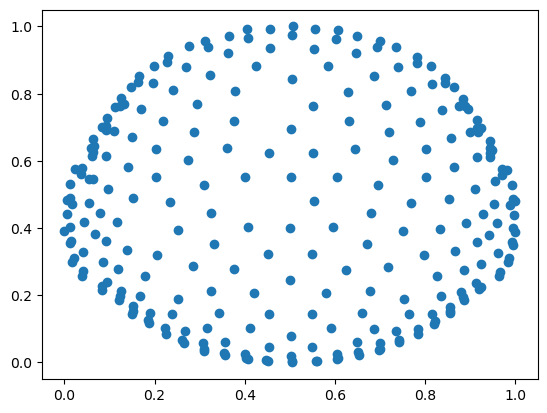

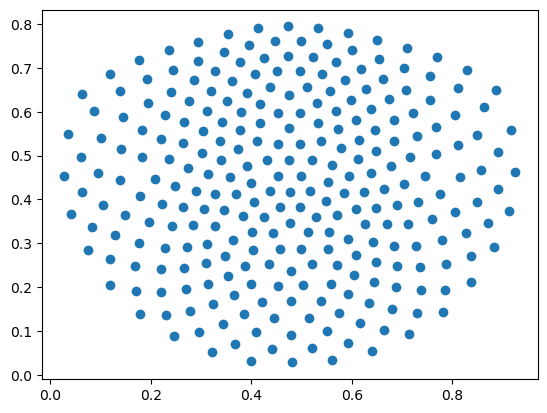

In [90]:
import matplotlib.pyplot as plt

plt.scatter([x[0] for x in pos], [x[1] for x in pos])
layout = mne.find_layout(raw.info).pos[:, :2].tolist()
plt.show()
plt.scatter([x[0] for x in layout], [x[1] for x in layout])
plt.show()


In [7]:
import mne

fig = mne.viz.plot_alignment(
    raw.info,
    dig=False,
    eeg=False,
    surfaces=[],
    meg=["helmet", "sensors"],
    coord_frame="meg",
)
mne.viz.set_3d_view(fig, azimuth=50, elevation=90, distance=0.5)

RuntimeError: Could not load any valid 3D backend
pyvistaqt: No module named 'qtpy'
notebook: No module named 'ipyevents'

 install pyvistaqt, using pip or conda:
'pip install pyvistaqt'
'conda install -c conda-forge pyvistaqt'

 or install ipywidgets, if using a notebook backend
'pip install ipywidgets'
'conda install -c conda-forge ipywidgets'

In [ ]:
study.subjects_list[19]

'20'

In [8]:
from utils.fetch import fetch_audio_and_brain_pairs

brain_segments, audio_segments, layout = fetch_audio_and_brain_pairs(
    subject=subject,
    task=task,
    session=session,
    max_random_shift=max_random_shift,
    window_size=window_size,
    window_stride=1,
    study=study,
    pre_processor=pre_processor,
    frequency_bands=frequency_bands,
    new_freq=100,
    audio_sample_rate=16000,
    hop_length=160,
    n_jobs=-1,
)
brain_segments['all'].shape, audio_segments.shape, layout.shape

(torch.Size([202, 208, 400]),
 torch.Size([202, 128, 400]),
 torch.Size([208, 2]))

In [16]:
model = SimpleConv(SimpleConvConfig(transformer_layers=0, merger_pos_dim=512)).to('mps')

ChannelMerger: torch.Size([256, 512]), FT params: 0

SimpleConv: 
	Params: 14038912
	Conv blocks: 5
	Trans layers: 0


In [14]:
output = model(
    {"meg": brain_segments["all"].to('mps')},
    layout=layout.to('mps'),
    subjects=torch.full((brain_segments["all"].shape[0],), subject).to('mps'),
)

In [ ]:
output.shape

torch.Size([199, 128, 400])